# Final Standard Single Model for Timeseries with TSGenerator (no loss plot)

### Currently trying to make it work at par with the latest gridsearchCV parameters
### Next Steps:
1. Need to run experiments to chose num of layers and nodes in the layers
2. Need to ensure that the lag of 1 day in the predictions is removed

In [1]:
from datetime import datetime
dateTimeObj_Start = datetime.now()
print('Start time =', dateTimeObj_Start)

Start time = 2020-05-29 16:01:18.185725


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [3]:
train = pd.read_csv('Google_Stock_Price_Train.csv', index_col='Date',parse_dates=True)

In [4]:
test = pd.read_csv('Google_Stock_Price_Test.csv', index_col='Date',parse_dates=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null object
Volume    1258 non-null object
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
Open      20 non-null float64
High      20 non-null float64
Low       20 non-null float64
Close     20 non-null float64
Volume    20 non-null object
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


In [7]:
train = train[['Open']]

In [8]:
test = test[['Open']]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
Open    1258 non-null float64
dtypes: float64(1)
memory usage: 19.7 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 1 columns):
Open    20 non-null float64
dtypes: float64(1)
memory usage: 320.0 bytes


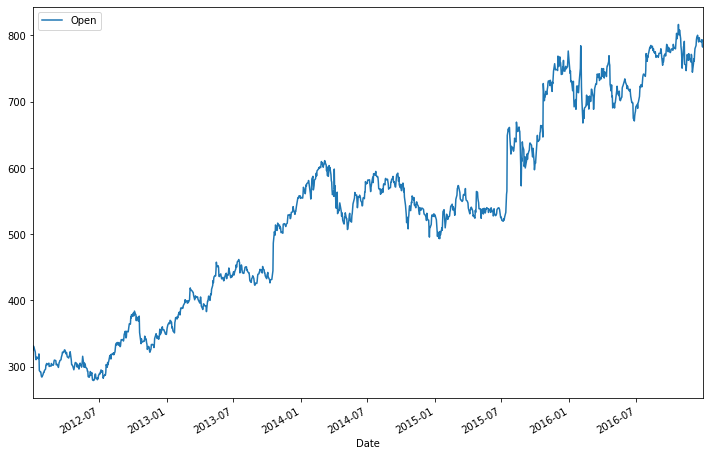

In [11]:
train.plot(figsize=(12,8))

In [12]:
#from statsmodels.tsa.seasonal import seasonal_decompose #Since the freq is not being able to set, statsmodel will not be used here.

## Train Test Split (Not required here)

In [13]:
#len(df)

In [14]:
#train = df.iloc[:313]
#test = df.iloc[313:]

## Scale Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Timeseriesgenerator

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


### < < Inputs > >

In [20]:
# n_input: This is the number of past record you want to use to predict the next value. 
    # It should be a multiple of seasonality if there is any. One should try with different values for a better result.
    # Larger the number, more number of features it will have so more training time for the model 
# Let's define to get 12 months back and then predict the next month out
n_in = 60 # This is because HAdelin used this after trying differnt values i.e. 20, 40 and then 60. 60 is for 3 months.
n_features = 1 # This is how many column we have for the model. for us its just the "Open" column hence 1.
batch_size = 1 # This is the number of batches of X and y that the generator can produce. 1 a good choice. bigger the number there could be overfitting.
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_in, batch_size=batch_size)

In [21]:
# What does the first batch look like?
X,y = generator[0]

In [22]:
#print(f'Given the Array: \n{X.flatten()}')
#print(f'Predict this y: \n {y}')

### Create the Model

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

### < < Inputs > >

# define model

In [24]:
#def createLSTMModel(optimizer, dropout_rate=0.2, learning_rate = 0.001, activation='relu', loss = 'mse', metrics = 'rmse'):
n_input = n_in
n_features = 1
activation='tanh'
optimizer='Nadam'
dropout_rate = 0.2
loss = 'mse'
kernel_initializer='glorot_uniform' #($ This could be changed for exploding or vanishing gradient but not mandatory to change)
optimizer = optimizers.Nadam(lr = 0.001)

model = Sequential()

model.add(LSTM(50, activation=activation, return_sequences = True, input_shape=(n_input, n_features), kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate)) 

model.add(LSTM(50, activation=activation, return_sequences = True, kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))

model.add(LSTM(50, activation=activation, return_sequences = True, kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))

model.add(LSTM(50, activation=activation, return_sequences = False, kernel_initializer=kernel_initializer))
model.add(Dropout(dropout_rate))

model.add(Dense(1, kernel_initializer=kernel_initializer))
model.compile(optimizer=optimizer, loss=loss)

In [28]:
model.summary()

NameError: name 'model' is not defined

### < < Inputs > >

In [ ]:
#model.fit() - We will not use this function as 'generator' generates the X and y on the go. Hadelin's   

In [ ]:
# fit model
model.fit_generator(generator,epochs=100,steps_per_epoch=n_in/batch_size)

In [ ]:
model.history.history.keys()

In [ ]:
loss_per_epoch = model.history.history['loss']
fig = plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Prediction - Evaluate on Test Data

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [ ]:
# Method 1: Predict for the n_out steps at one go and then use it as input to predict the output for the next step instead of actual known output for that timestamp from test set.
    # ..This is more realistic as for the real future prediction this is how it will be predicted. Method 2 below uses the real actual value for a timestamp instead of using the one that is predicted by the model. 
    # ..this is only for finding the performance on the test set. However to predict just a single timestamp say to predict the stock price for the next day only, method 2 is more appropriate.    
test_predictions_m1 = []

first_eval_batch = scaled_train[-n_in:]
current_batch = first_eval_batch.reshape((1, n_in, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions_m1.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     
true_predictions_m1 = scaler.inverse_transform(test_predictions_m1) ##### [test_prediction] syntax is differnt from single model code

# Add predictions as a column to 'test' to plot on top of actual values
test['Jose_predictions'] = true_predictions_m1

In [ ]:
current_batch[0].shape

In [ ]:
#Method 4: Pramod from Timeseriesgenerator (easiest so far)
scaled_X_test = np.concatenate((scaled_train[-n_in:], scaled_test[:]))
generator1 = TimeseriesGenerator(scaled_X_test, scaled_X_test, length=n_in, batch_size=1)
X_test = []
for i in range(len(generator1)):
    X,y = generator1[i]
    X = np.reshape(X, (X.shape[0], X.shape[1])).T
    X_test.append(X)
X_test = np.array(X_test)

# Predictions
test_predictions_m4 = model.predict(X_test)
true_predictions_m4 = scaler.inverse_transform(test_predictions_m4) ##### [test_prediction] syntax is differnt from single model code

# Transpose the predictions to make a column
#true_predictions_m4 = np.transpose(true_predictions_m4)

# Add predictions as a column to 'test' to plot on top of actual values
test['My_method_predictions'] = true_predictions_m4

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
train[-60:].plot()
test.plot()

In [ ]:
loss_per_epoch = model.history.history['loss']
fig = plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test.columns

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_jose = np.sqrt(mean_squared_error(test.Open, test.Jose_predictions))
rmse_jose

In [ ]:
rmse_Hadelin = np.sqrt(mean_squared_error(test.Open, test.My_method_predictions))
rmse_Hadelin

In [ ]:
test.Open.mean()

In [ ]:
from datetime import datetime
dateTimeObj_End = datetime.now()
print('End time =', dateTimeObj_End)

In [ ]:
total_runtime = dateTimeObj_End - dateTimeObj_Start
total_runtime

# Saving and Loading Models

In [ ]:
#model.save('my_rnn_model.h5')

## load a model

In [ ]:
#from keras.models import load_model
#new_model = load_model('my_rnn_model.h5')
#new_model.summary()

In [ ]:
#new_model.summary()